# Notebook to create single-slice 2D multiplicative factors and brainweb image for single slice mMR 

Use [measured data](https://github.com/SyneRBI/SIRF-Exercises/blob/master/notebooks/PET/reconstruct_measured_data.ipynb) and [brainweb]](https://github.com/SyneRBI/SIRF-Exercises/blob/master/notebooks/Synergistic/BrainWeb.ipynb) for some more information

In [ ]:
import brainweb
import os
import numpy as np
import sirf.STIR as stir
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [69]:
from sirf.Utilities import examples_data_path
data_path = examples_data_path('PET')

In [70]:
def crop_and_fill(templ_im, vol):
    """Crop volumetric image data and replace image content in template image object"""
    # Get size of template image and crop
    idim_orig = templ_im.as_array().shape
    idim = (1,)*(3-len(idim_orig)) + idim_orig
    offset = (np.array(vol.shape) - np.array(idim)) // 2
    vol = vol[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1], offset[2]:offset[2]+idim[2]]
    
    # Make a copy of the template to ensure we do not overwrite it
    templ_im_out = templ_im.copy()
    
    # Fill image content 
    templ_im_out.fill(np.reshape(vol, idim_orig))
    return(templ_im_out)

In [71]:
mmR_data_path = os.path.join(data_path, 'mMR')
print(mmR_data_path)

/home/sam/devel/SIRF_builds/master/build/INSTALL/share/SIRF-3.8/data/examples/PET/mMR


In [72]:
acq_data_small = stir.AcquisitionData(os.path.join(mmR_data_path, 'mMR_template_span11_small.hs'))
acq_data_single_slice = stir.AcquisitionData(os.path.join(mmR_data_path, 'mMR_template_single_slice.hs'))


INFO: Detected view-mashing factor 2 from the number of views (126) and the number of detectors per ring (504).
Adjusting the azimuthal angle offset accordingly (an extra offset of 0.357143 degrees)

INFO: Interfile parsing ended up with the following scanner:
Scanner parameters:=
  Scanner type := userdefined
  Number of rings                          := 2
  Number of detectors per ring             := 504
  Inner ring diameter (cm)                 := 65.6
  Average depth of interaction (cm)        := 0.7
  Distance between rings (cm)              := 0.40625
  Default bin size (cm)                    := 0.208626
  View offset (degrees)                    := 0
  Maximum number of non-arc-corrected bins := 344
  Default number of arc-corrected bins     := 344
  Number of blocks per bucket in transaxial direction         := 1
  Number of blocks per bucket in axial direction              := 2
  Number of crystals per block in axial direction             := 1
  Number of crystals per block

In [73]:
asm_norm = stir.AcquisitionSensitivityModel(os.path.join(mmR_data_path, 'norm.n.hdr'))

Reading manufacturer PET normalisation file from /home/sam/devel/SIRF_builds/master/build/INSTALL/share/SIRF-3.8/data/examples/PET/mMR/norm.n.hdr
trying GEHDF5...


not a GE HDF5 file


In [74]:
asm_norm.set_up(acq_data_small)
det_efficiencies_small=acq_data_small.get_uniform_copy(1)
asm_norm.unnormalise(det_efficiencies_small)
print(det_efficiencies_small.shape)

(1, 357, 126, 344)


In [75]:
det_efficiencies_2D = det_efficiencies_small.rebin(3)
print(det_efficiencies_2D.shape)

(1, 127, 126, 344)


In [76]:
selected_slice = det_efficiencies_2D.shape[1] // 2
det_efficiencies_single_slice_arr = np.expand_dims(det_efficiencies_2D.as_array()[:, selected_slice, :, :], axis=0)
det_efficiencies_single_slice = acq_data_single_slice.copy()
det_efficiencies_single_slice.fill(det_efficiencies_single_slice_arr)
print(det_efficiencies_single_slice.shape)

(1, 1, 126, 344)





ERROR: ProjDataFromStream: error reading data


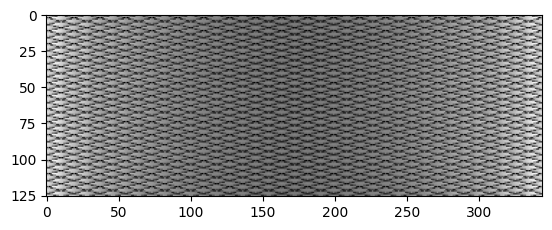

In [77]:
plt.imshow(det_efficiencies_single_slice.as_array().squeeze(), cmap='gray')

In [78]:
fname, url= sorted(brainweb.utils.LINKS.items())[0] # select first link
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)
    
for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)
    vol_amyl = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1, PetClass=brainweb.Amyloid)
     

mMR ground truths:   0%|          | 0/1 [00:00<?, ?subject/s]

In [79]:
uMap_arr = vol['uMap']
amyl_arr = vol_amyl['PET']
fdg_arr = vol['PET']

In [80]:
# Select central slice
central_slice = fdg_arr.shape[0]//2
fdg_arr = fdg_arr[central_slice, :, :]
amyl_arr = amyl_arr[central_slice, :, :]
uMap_arr = uMap_arr[central_slice, :, :]
# Select a central ROI with 155x155
# We could also skip this because it is automaticall done by crop_and_fill() 
# but we would like to check if we did the right thing
idim = 155
offset = (np.array(fdg_arr.shape) - np.array(idim)) // 2
fdg_arr = fdg_arr[offset[0]:offset[0]+idim, offset[1]:offset[1]+idim]
amyl_arr = amyl_arr[offset[0]:offset[0]+idim, offset[1]:offset[1]+idim]
uMap_arr = uMap_arr[offset[0]:offset[0]+idim, offset[1]:offset[1]+idim]

# Now we make sure our image is of shape (1, 120, 120) again because in __SIRF__ even 2D images 
# are expected to have 3 dimensions.
fdg_arr = fdg_arr[np.newaxis,...]
amyl_arr = amyl_arr[np.newaxis,...]
uMap_arr = uMap_arr[np.newaxis,...]

In [81]:
im = acq_data_single_slice.create_uniform_image(0, xy=idim)
fdg = crop_and_fill(im, fdg_arr)
amyl = crop_and_fill(im, amyl_arr)
uMap = crop_and_fill(im, uMap_arr)


INFO: Determined voxel size by dividing default_bin_size (2.08626) by zoom


In [82]:
print(fdg.shape)
print(fdg.voxel_sizes())
print(type(fdg))

(1, 155, 155)
(2.03125, 3.8360264, 3.8360264)
<class 'sirf.STIR.ImageData'>


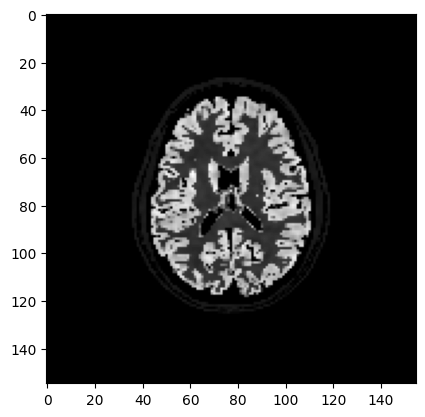

In [83]:
plt.imshow(fdg.as_array().squeeze(), cmap='gray')